## AAE Params Tuning

In [5]:
from networks.aae import *
import torch
import sys
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import os

DEFAULT_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized/slf_mat'

class SLF(Dataset):
    def __init__(self, root=DEFAULT_ROOT, train=True, download=True, transform=None, total_data=None):
        self.root_dir = root
        if not total_data is None:
            self.num_examples = total_data
        else:
            if train == True:
                self.num_examples = 500000
            else:
                self.num_examples = 2000
    
    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        filename = os.path.join(self.root_dir,
                                str(idx)+'.pt')
        sample = torch.load(filename)
        return sample

import os
# Insert your own path here

variation = "B-VAE"

# ds_path = os.path.join(".", "drive", "My Drive", "Machine Learning", "Datasets")

# configuration = {
#     "dataset": "MNIST",
#     "path": ds_path
# }

ds_path = DEFAULT_ROOT
configuration = {
    "dataset": "SLF",
    "path": ds_path
}


architecture = {
    "conv_layers": 5,
    "conv_channels": [32, 64, 128, 256, 512],
    "conv_kernel_sizes": [(4, 4), (4, 4), (4, 4), (4, 4), (3,3)],
    "conv_strides": [(2, 2), (2, 2), (2, 2), (2, 2), (1,1)],
    "conv_paddings": [(1, 1), (1, 1), (1, 1), (1, 1), (1,1)],
    "z_dimension": 64
}

hyperparameters = {
    "epochs": 10,
    "batch_size": 16,
    "learning_rate": 3e-6,
}

def prepare_dataset(configuration):
    """
    :param dict configuration: The configuration dictionary returned by parse_config_file

    :return:        A dictionary containing information about the dataset used

    Function used to set some values used by the model based on the dataset selected
    """
    dataset_info = {}
    if (configuration["dataset"] == "MNIST"):
        dataset_info["ds_method"] = torchvision.datasets.MNIST
        dataset_info["ds_shape"] = (1, 28, 28)
        dataset_info["ds_path"] = configuration["path"]
    elif (configuration["dataset"] == "CIFAR10"):
        dataset_info["ds_method"] = torchvision.datasets.CIFAR10
        dataset_info["ds_shape"] = (3, 32, 32)
        dataset_info["ds_path"] = configuration["path"]
    elif (configuration["dataset"] == "FashionMNIST"):
        dataset_info["ds_method"] = torchvision.datasets.FashionMNIST
        dataset_info["ds_shape"] = (1, 28, 28)
        dataset_info["ds_path"] = configuration["path"]
    elif configuration['dataset'] == 'SLF':
        dataset_info['ds_method'] = SLF
        dataset_info['ds_shape'] = (1, 51, 51)
        dataset_info['ds_path'] = configuration['path']
    else:
        print("Currently only MNIST & CIFAR10 datasets are supported")
        return None

    return dataset_info

dataset_info = prepare_dataset(configuration)

## Tune AAE parameters

In [ ]:
from collections import OrderedDict, namedtuple
import os
from run_manager_adv import RunBuilder, RunManager
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

DEFAULT_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')

params = OrderedDict(
    lr = [0.0001, 0.00001, 0.000001],
    batch_size = [64],
    device = devices,
    shuffle = [True],
    num_workers = [5], 
    z_dim = [16]
)

train_set = SLF(root=os.path.join(DEFAULT_ROOT, 'slf_mat'), total_data=500000)

m = RunManager(epoch_count_print=1)

real_label = 0.9
fake_label = 0

criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
alpha = 0.0001
Tc = 0
Td = 0
T_train = 100

count=0
run_data = []
models = []
for run in RunBuilder.get_runs(params):
    architecture['z_dimension'] = run.z_dim
    device = torch.device(run.device)
    encoder = Encoder(architecture, dataset_info).to(run.device)
    decoder = Decoder(architecture, dataset_info).to(run.device)
    discriminator = Discriminator(architecture['z_dimension']).to(run.device)

    loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size, shuffle=run.shuffle, num_workers=run.num_workers)
    optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr=run.lr)
    optimizerDecoder = torch.optim.Adam(decoder.parameters(), lr=run.lr)
    optimizerDiscriminator = torch.optim.Adam(discriminator.parameters(), lr=run.lr)
    
    m.begin_run(run, encoder, loader)
    
# # Assuming optimizer has two groups.
# lambda_group1 = lambda epoch: epoch // 30
# lambda_group2 = lambda epoch: 0.95 ** epoch
# scheduler = LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
    num_batches = len(train_set)/run.batch_size

    for epoch in range(15):
#         if epoch>5:
            
        m.begin_epoch()    

        total_gen_loss = 0
        total_d_loss = 0
        total_mse_loss = 0
 
        real_count = 0
        fake_count = 0
        
        total_D_real = 0
        total_D_fake = 0
        
        
        for batch in tqdm(loader):
            # Get data
            in_features = batch
            in_features = in_features.to(run.device)
            b_size = in_features.size(0)
            labels_real = torch.full((b_size,1), real_label, device=run.device, dtype=torch.float32)
            labels_fake = torch.full((b_size,1), fake_label, device=run.device, dtype=torch.float32)
            
            # Update Autoencoder using MSE loss
            optimizerEncoder.zero_grad()
            optimizerDecoder.zero_grad()
            fake_latent = encoder(in_features)
            x_hat = decoder(fake_latent)
            
            ae_loss = l2_loss(in_features, x_hat)
            ae_loss.backward()
            optimizerEncoder.step()
            optimizerDecoder.step()
            
            # Update generator(encoder) of GAN using adversarial loss
            optimizerEncoder.zero_grad()
            fake_latent = encoder(in_features)
            gen_loss = criterion(discriminator(fake_latent), labels_real)
            gen_loss.backward()
            optimizerEncoder.step()
 
            # Update discrimintator of GAN using adversarial loss
            optimizerDiscriminator.zero_grad()
            
            fake_latent = encoder(in_features)
            fake_pred = discriminator(fake_latent)
            fake_loss = criterion(fake_pred, labels_fake)
            
            real_latent = torch.randn_like(fake_latent)
            real_pred = discriminator(real_latent)
            real_loss = criterion(real_pred, labels_real)
            
            loss_discriminator = 0.5*(real_loss + fake_loss)
            loss_discriminator.backward()
            optimizerDiscriminator.step()
            
            count_real = real_pred.mean().item()
            count_fake = fake_pred.mean().item()
                        
            # Total loss
            total_D_real += real_loss.item()
            total_D_fake += fake_loss.item()
        
            total_mse_loss += ae_loss.item()
            total_gen_loss += gen_loss.item()
            total_d_loss += loss_discriminator.item()
            
            
            count += 1
            
        results = OrderedDict()
        results['gen_loss'] = total_gen_loss/num_batches
        results['d_loss'] = total_d_loss/num_batches
        results['mse'] = total_mse_loss/num_batches
        results['lr'] = run.lr
        results['batch_size'] = [run.batch_size]
        run_data.append(results)
        
        
        
        df = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
        # plot the losses
#         plt.cla()
#         plt.plot(epoch, results['gen_loss'])
#         plt.plot(epoch, results['d_loss'])
#         plt.plot(epoch, results['mse'])
#         plt.show()
        
        display(df)
    torch.save(decoder, 'trained-models/aae/lr_{}_z_dim_{}'.format(run.lr, run.z_dim))
    models.append(decoder)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
    m.end_run()
df.to_pickle('trained-models/aae/loss_df')
# torch.save('trained-models/models')

,gen_loss,d_loss,mse,lr,batch_size
0,0.545360,0.752457,0.002088,0.00010,[64]
1,0.771909,0.688613,0.000211,0.00010,[64]
2,0.778490,0.688183,0.000039,0.00010,[64]
3,0.778490,0.688183,0.000029,0.00010,[64]
4,0.778490,0.688183,0.000026,0.00010,[64]
5,0.778490,0.688183,0.000022,0.00010,[64]
6,0.778490,0.688183,0.000020,0.00010,[64]
7,0.778490,0.688183,0.000019,0.00010,[64]
8,0.778490,0.688183,0.000017,0.00010,[64]
9,0.778490,0.688183,0.000016,0.00010,[64]


 88%|████████▊ | 6907/7813 [06:19<00:49, 18.26it/s]

In [54]:
df.to_pickle('trained-models/aae/df')

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

decoder = torch.load('trained-models/aae/lr_0.0001_z_dim_16')

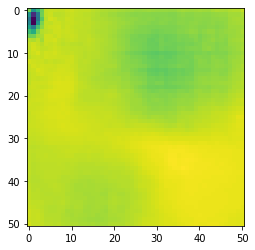

In [38]:
a = torch.randn((1,64), dtype=torch.float32)
decoder.eval()
decoder = decoder.to('cpu')

b = decoder(a)
plt.imshow(np.log(b.detach().squeeze().numpy()))

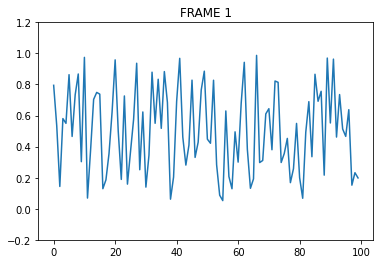

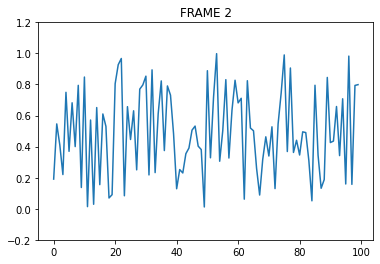

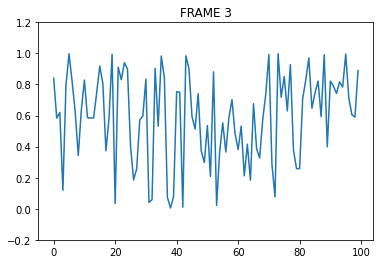

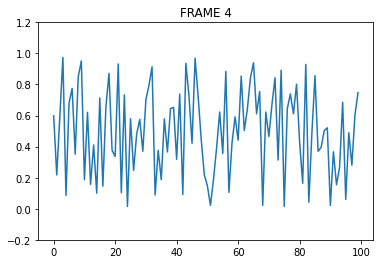

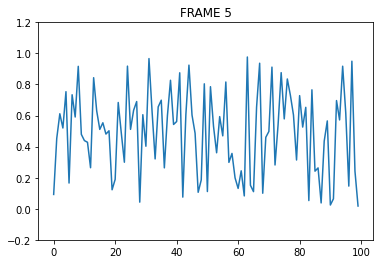

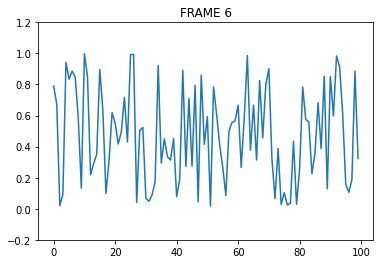

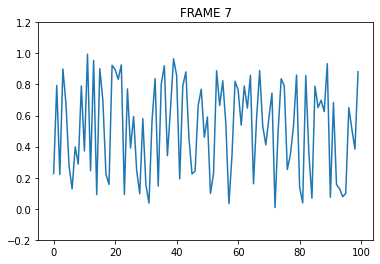

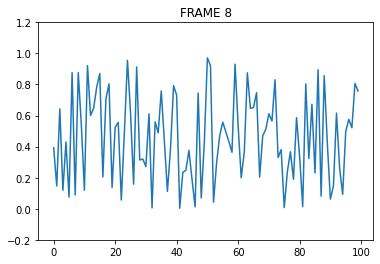

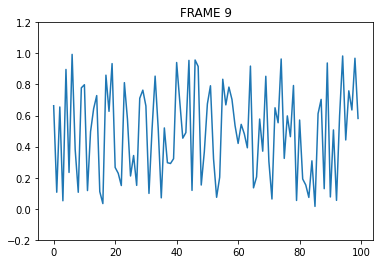

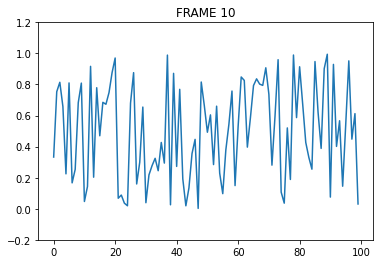

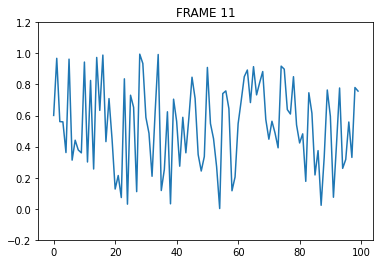

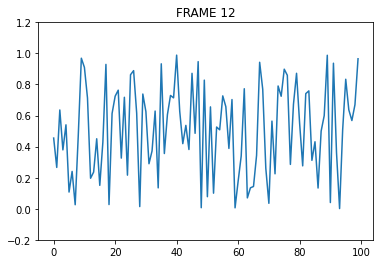

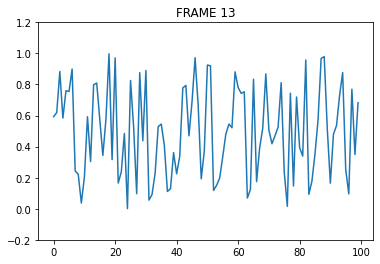

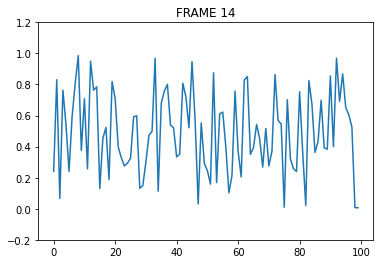

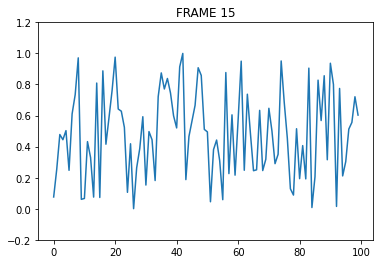

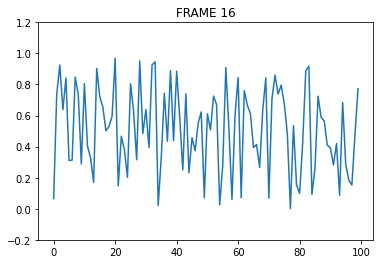

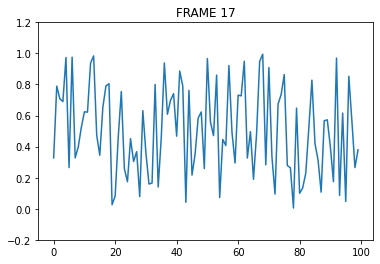

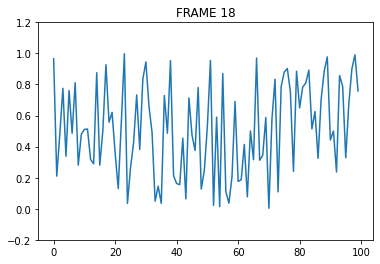

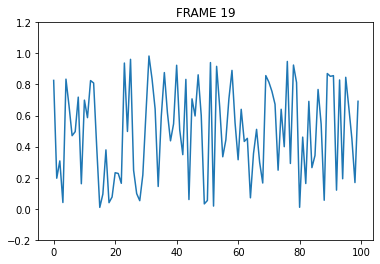

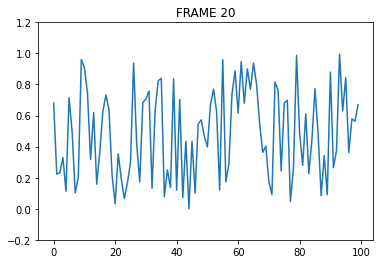

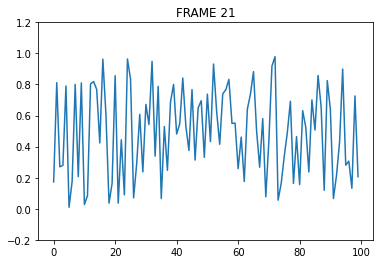

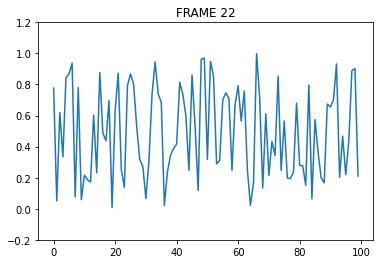

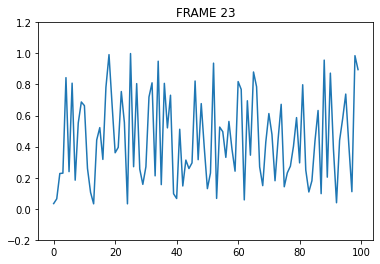

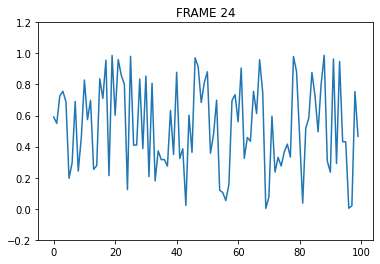

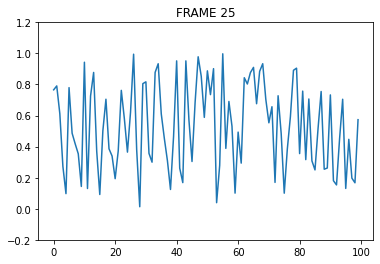

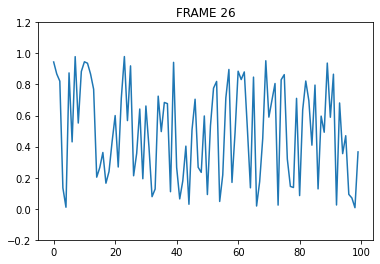

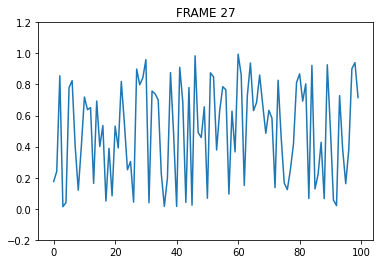

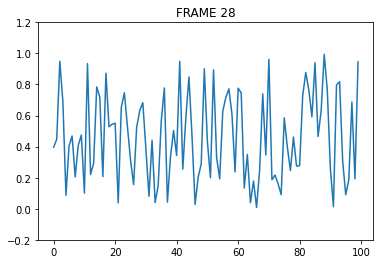

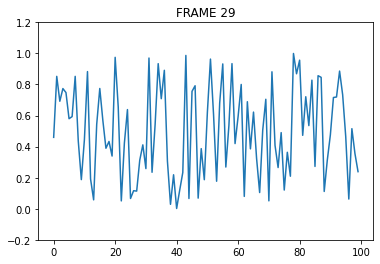

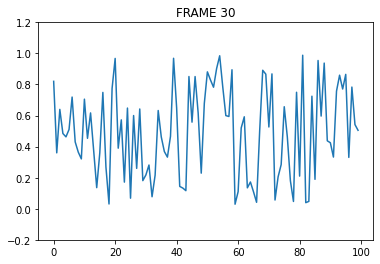

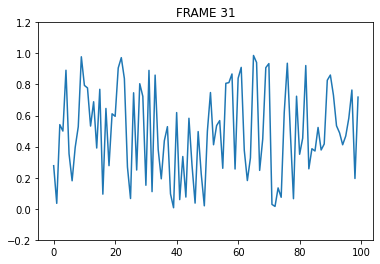

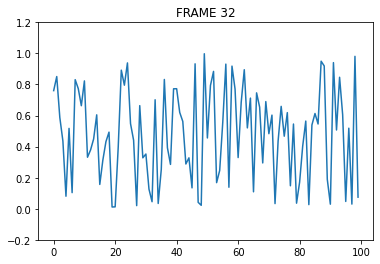

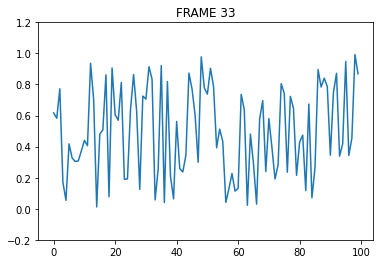

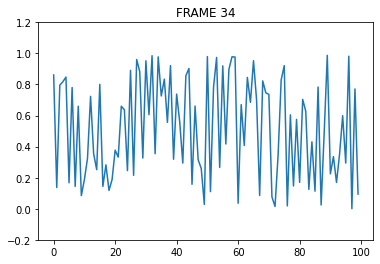

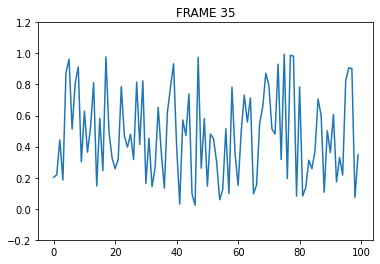

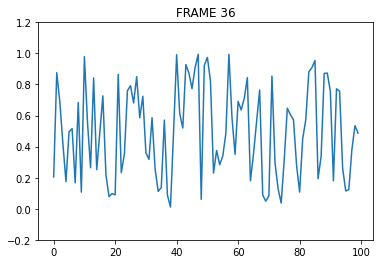

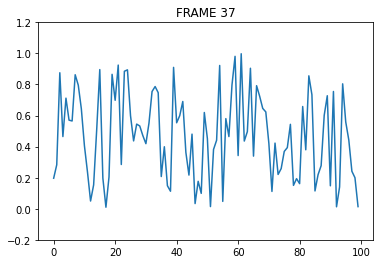

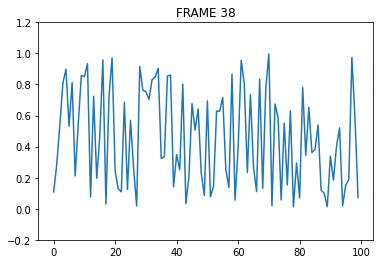

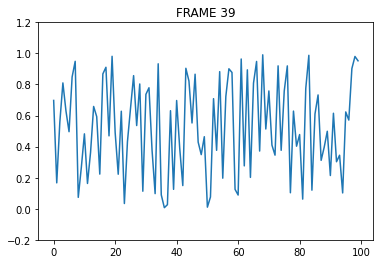

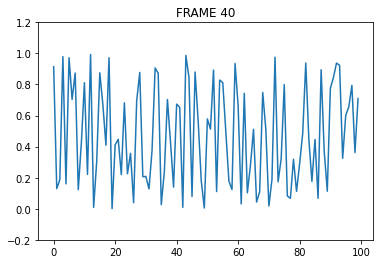

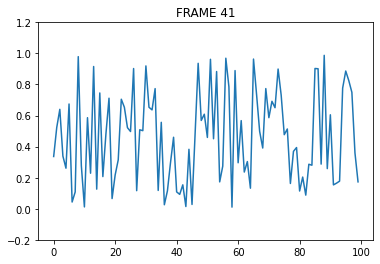

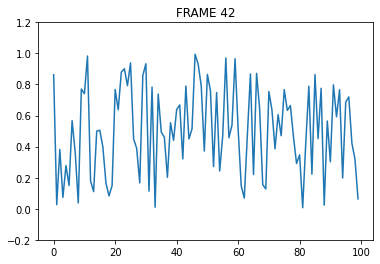

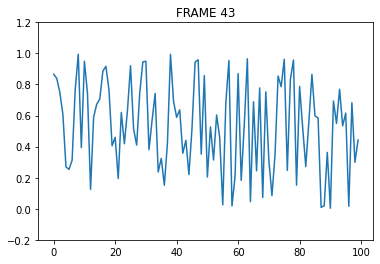

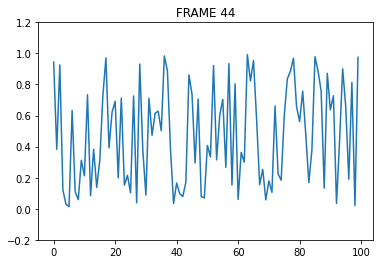

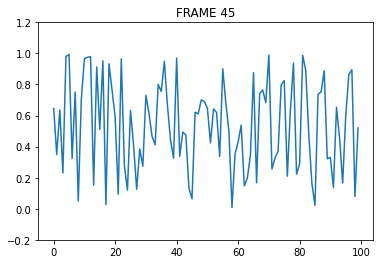

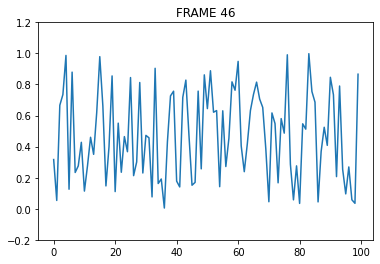

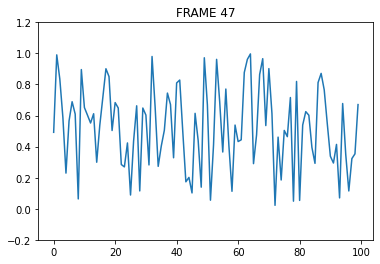

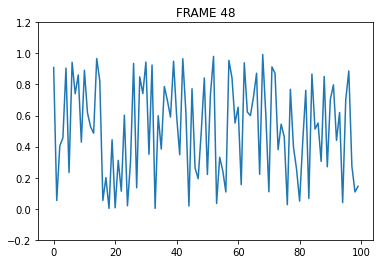

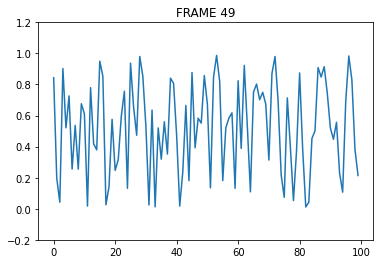

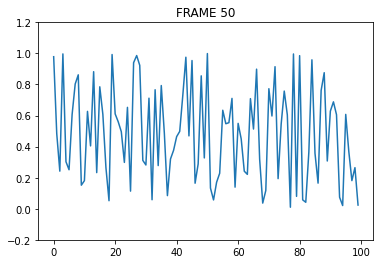

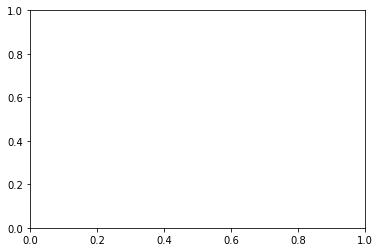

In [22]:
%matplotlib inline
MEASUREMENT_TIME = 50
INTERVAL_SEC = 0.1

for i in range(MEASUREMENT_TIME):
    # replace with your data
    data = np.random.rand(100)

    plt.plot(data)

    # figure appearence adjustments
    plt.ylim(-0.2, 1.2)
    plt.title(f'FRAME {i+1}')

    # to avoid clearing last plot
    if (i != MEASUREMENT_TIME*10-1):
        plt.draw()
        plt.pause(INTERVAL_SEC)
        plt.cla()
    else:
        plt.show()


In [16]:
torch.save(encoder,'trained-models/aae-encoder-1')
torch.save(decoder,'trained-models/aae-decoder-1')
torch.save(discriminator,'trained-models/aae-discriminator-1')


In [4]:
import torch
import torch.nn as nn

encoder = torch.load('trained-models/aae/aae-encoder-1')
decoder = torch.load('trained-models/aae/aae-decoder-1')
discriminator = torch.load('trained-models/aae/aae-discriminator-1')

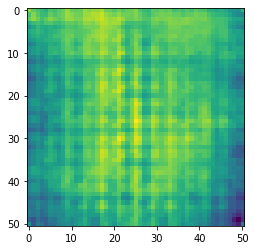

In [53]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

decoder.eval()
decoder = decoder.to('cpu')

a = torch.randn((1,64), dtype=torch.float32)
b = decoder(a)
plt.imshow(np.log(b.detach().squeeze().numpy()))